# 2. Estimating the Discount Curve with Non-Evenly Spaced Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## 2.1 Map Cashflows - Full Dataset

full_data = pd.read_excel('data/treasury_quotes_2025-11-28.xlsx', sheet_name='quotes')
full_data[['quote date', 'issue date', 'maturity date']] = full_data[['quote date', 'issue date', 'maturity date']].apply(pd.to_datetime)
quote_date = full_data['quote date'].iloc[0]

# Remove missing/negative YTM
full_data_clean = full_data.dropna(subset=['ytm']).query('ytm >= 0')
print(f"Bonds: {len(full_data)} → {len(full_data_clean)} after filtering")

# Generate cashflows
cashflow_matrix = {}
for idx, row in full_data_clean.iterrows():
    coupon_pmt = row['cpn rate'] / 2
    cashflow_dates = pd.date_range(start=row['issue date'], end=row['maturity date'], freq='6MS')
    
    if len(cashflow_dates) == 0 or cashflow_dates[-1] != row['maturity date']:
        cashflow_dates = cashflow_dates.append(pd.DatetimeIndex([row['maturity date']]))
    
    cashflow_dates = cashflow_dates[cashflow_dates > quote_date]
    cashflow_matrix[idx] = {date: (coupon_pmt + 100 if date == row['maturity date'] else coupon_pmt) 
                            for date in cashflow_dates}

# Build matrix
all_dates = sorted(set(date for cf in cashflow_matrix.values() for date in cf))
C_full = pd.DataFrame(0.0, index=full_data_clean.index, columns=all_dates)
for bond_id, cashflows in cashflow_matrix.items():
    for date, amount in cashflows.items():
        C_full.loc[bond_id, date] = amount

print(f"Cashflow matrix: {C_full.shape}")

# Display
print("\n=== Head (5×5) ===")
display(C_full.iloc[:5, :5])
print("\n=== Tail (5×5) ===")
display(C_full.iloc[-5:, -5:])

# Analysis
total_cf = C_full.sum(axis=0)
num_issues = (C_full > 0).sum(axis=0)

max_cf_date = total_cf.idxmax()
max_issues_date = num_issues.idxmax()

print(f"\n=== Analysis ===")
print(f"Date with most cashflow: {max_cf_date.date()} (${total_cf.max():,.2f})")
print(f"Date with most issues:   {max_issues_date.date()} ({num_issues.max()} issues)")
print(f"Total payment dates: {len(all_dates)}")

Bonds: 455 → 402 after filtering
Cashflow matrix: (402, 440)

=== Head (5×5) ===


,2025-12-01,2025-12-02,2025-12-04,2025-12-09,2025-12-11
0,0.0,100.0,0.0,0.0,0.0
1,0.0,0.0,100.0,0.0,0.0
2,0.0,0.0,0.0,100.0,0.0
3,0.0,0.0,0.0,0.0,100.0
4,0.0,0.0,0.0,0.0,0.0



=== Tail (5×5) ===


,2055-03-01,2055-05-15,2055-06-01,2055-08-15,2055-11-15
449,0.000,0.000,0.0000,0.000,0.0000
451,0.000,0.000,0.0000,0.000,0.0000
452,0.000,102.375,0.0000,0.000,0.0000
453,2.375,0.000,0.0000,102.375,0.0000
454,0.000,0.000,2.3125,0.000,102.3125



=== Analysis ===
Date with most cashflow: 2026-04-30 ($404.00)
Date with most issues:   2025-12-01 (106 issues)
Total payment dates: 440


## Filtered Cashflow Matrix $\hat{\mathbf{C}}$

### Filtering Criteria

From the full cashflow matrix $\mathbf{C}$, we create $\hat{\mathbf{C}}$ such that:

1. **Every column** corresponds to a bond maturity date
2. **Every row** (bond) has its maturity date in the column set

Mathematically:
$$\hat{\mathbf{C}} = \mathbf{C}[:, \mathcal{M}][\mathcal{I}_{\mathcal{M}}, :]$$

where:
- $\mathcal{M}$ = set of maturity dates
- $\mathcal{I}_{\mathcal{M}}$ = indices of bonds whose maturity $\in \mathcal{M}$

### OLS Estimation

Solve for discount factors:
$$\hat{\mathbf{p}} = \hat{\mathbf{C}} \hat{\mathbf{z}}$$

$$\hat{\mathbf{z}} = (\hat{\mathbf{C}}^T \hat{\mathbf{C}})^{-1} \hat{\mathbf{C}}^T \hat{\mathbf{p}}$$

where $\hat{\mathbf{p}}$ contains dirty prices of filtered bonds.

### Rate Conversion

Semiannually compounded rate from discount factor:
$$r_{sa}(t) = 2\left(Z(t)^{-1/(2t)} - 1\right)$$

Original matrix: (402, 440)
Filtered matrix (C_hat): (402, 270)
Maturity dates in columns: 270
Bonds with maturity in matrix: 402

=== C_hat Head (5×5) ===


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15
0,100.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0
4,0.0,0.0,0.0,0.0,102.0



=== C_hat Tail (5×5) ===


,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
449,102.25,0.0000,0.000,0.000,0.0000
451,0.00,102.3125,0.000,0.000,0.0000
452,0.00,0.0000,102.375,0.000,0.0000
453,0.00,0.0000,0.000,102.375,0.0000
454,0.00,0.0000,0.000,0.000,102.3125



=== Discount Factors Summary ===
                      date  discount_factor         ttm     rate_sa
count                  270       270.000000  270.000000  270.000000
mean   2033-08-07 11:44:00         0.943180    7.691961    0.013474
min    2025-12-02 00:00:00         0.494351    0.010951   -0.008627
25%    2026-10-18 12:00:00         0.952414    0.888433    0.001267
50%    2029-11-07 12:00:00         0.985387    3.943874    0.010246
75%    2038-12-08 00:00:00         0.997540   13.026694    0.023494
max    2055-11-15 00:00:00         1.059831   29.963039    0.039877
std                    NaN         0.104407    8.806872    0.014228


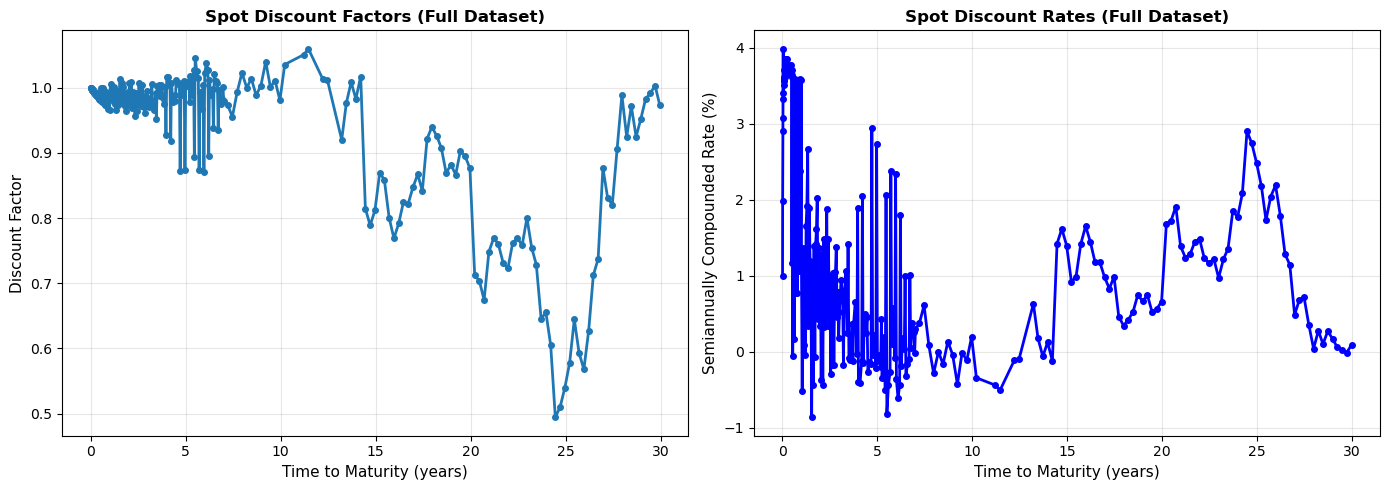


=== Rate Statistics ===
Rate range: -0.863% to 3.988%
Mean rate: 1.347%


In [4]:
## 2.2 OLS Estimation with Filtered Cashflows

# Identify maturity dates for each bond
maturity_dates = set(pd.to_datetime(full_data_clean['maturity date']))

# Filter columns: only keep dates that are maturity dates
C_hat = C_full[C_full.columns[C_full.columns.isin(maturity_dates)]].copy()

# Filter rows: only keep bonds whose maturity is in the column set
bonds_with_maturity = full_data_clean[full_data_clean['maturity date'].isin(C_hat.columns)].index
C_hat = C_hat.loc[bonds_with_maturity]

print(f"Original matrix: {C_full.shape}")
print(f"Filtered matrix (C_hat): {C_hat.shape}")
print(f"Maturity dates in columns: {C_hat.shape[1]}")
print(f"Bonds with maturity in matrix: {C_hat.shape[0]}")

# Display head and tail
print("\n=== C_hat Head (5×5) ===")
display(C_hat.iloc[:5, :5])
print("\n=== C_hat Tail (5×5) ===")
display(C_hat.iloc[-5:, -5:])

# Solve for discount factors using OLS
p_hat = full_data_clean.loc[C_hat.index, 'dirty price'].values
C_hat_mat = C_hat.values

z_hat = np.linalg.lstsq(C_hat_mat, p_hat, rcond=None)[0]

# Create discount factors DataFrame
discount_factors_full = pd.DataFrame({
    'date': C_hat.columns,
    'discount_factor': z_hat,
    'ttm': (pd.to_datetime(C_hat.columns) - quote_date).days / 365.25
})

discount_factors_full = discount_factors_full[discount_factors_full['ttm'] > 0].sort_values('ttm')

# Calculate semiannually compounded rates
discount_factors_full['rate_sa'] = 2 * (discount_factors_full['discount_factor']**(-1/(2*discount_factors_full['ttm'])) - 1)

print("\n=== Discount Factors Summary ===")
print(discount_factors_full.describe())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Discount Factors
axes[0].plot(discount_factors_full['ttm'], discount_factors_full['discount_factor'], 'o-', 
             linewidth=2, markersize=4)
axes[0].set_xlabel('Time to Maturity (years)', fontsize=11)
axes[0].set_ylabel('Discount Factor', fontsize=11)
axes[0].set_title('Spot Discount Factors (Full Dataset)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Semiannual Rates
axes[1].plot(discount_factors_full['ttm'], discount_factors_full['rate_sa'] * 100, 'o-', 
             linewidth=2, markersize=4, color='blue')
axes[1].set_xlabel('Time to Maturity (years)', fontsize=11)
axes[1].set_ylabel('Semiannually Compounded Rate (%)', fontsize=11)
axes[1].set_title('Spot Discount Rates (Full Dataset)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Rate Statistics ===")
print(f"Rate range: {discount_factors_full['rate_sa'].min()*100:.3f}% to {discount_factors_full['rate_sa'].max()*100:.3f}%")
print(f"Mean rate: {discount_factors_full['rate_sa'].mean()*100:.3f}%")

=== Nelson-Siegel Parameters (Full Dataset) ===
β₀ (level):      0.015089 (1.5089%)
β₁ (slope):      0.023452 (2.3452%)
β₂ (curvature):  -0.077038 (-7.7038%)
τ (decay):       2.001965 years
Success: True


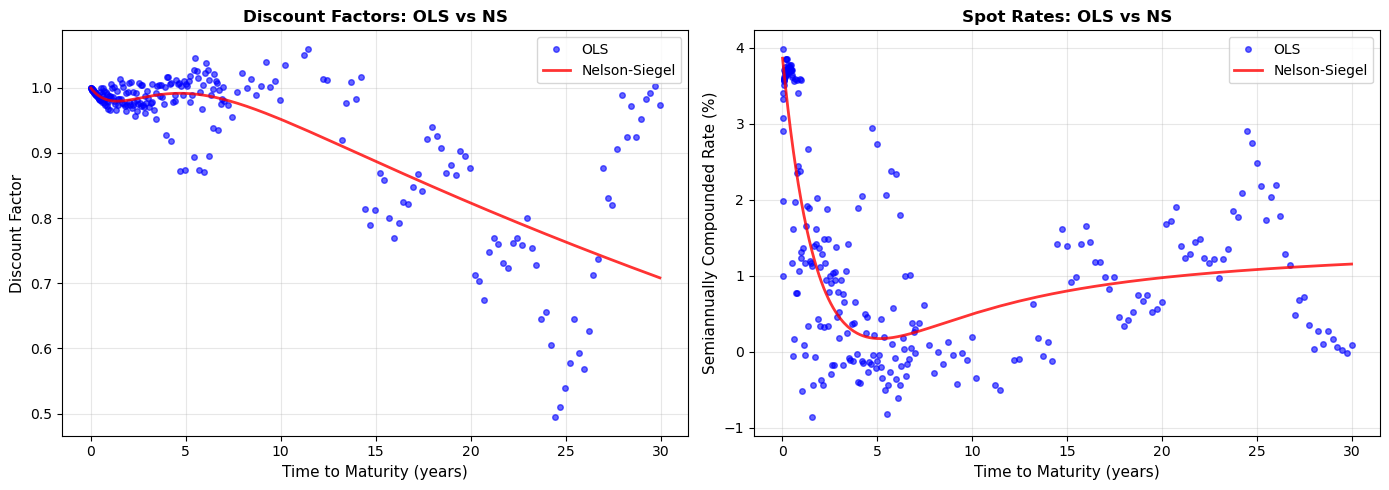


=== Fit Quality ===
Mean Absolute Error: 63.32 bps
Max Absolute Error:  287.12 bps
RMSE:                83.17 bps


In [5]:
## 2.3 Nelson-Siegel Model - Full Dataset

from scipy.optimize import minimize

def nelson_siegel_rate(ttm, beta0, beta1, beta2, tau):
    """Nelson-Siegel continuously compounded spot rate."""
    ttm = np.maximum(ttm, 1e-10)
    tau = np.maximum(tau, 0.1)
    x = ttm / tau
    exp_x = np.exp(-x)
    return beta0 + beta1 * (1 - exp_x) / x + beta2 * ((1 - exp_x) / x - exp_x)

def ns_objective(params, ttm, observed_rates):
    """Sum of squared errors."""
    beta0, beta1, beta2, tau = params
    predicted_rates = nelson_siegel_rate(ttm, beta0, beta1, beta2, tau)
    return np.sum((observed_rates - predicted_rates) ** 2)

# Calculate continuous rates from OLS
discount_factors_full['rate_cc'] = -np.log(discount_factors_full['discount_factor']) / discount_factors_full['ttm']

# Fit Nelson-Siegel
ttm_vals = discount_factors_full['ttm'].values
ols_rates_cc = discount_factors_full['rate_cc'].values

initial_params = [0.04, -0.01, 0.0, 2.0]
bounds = [(0.0, 0.15), (-0.15, 0.15), (-0.15, 0.15), (0.5, 10.0)]

result = minimize(ns_objective, initial_params, args=(ttm_vals, ols_rates_cc),
                 method='L-BFGS-B', bounds=bounds)

beta0, beta1, beta2, tau = result.x

print("=== Nelson-Siegel Parameters (Full Dataset) ===")
print(f"β₀ (level):      {beta0:.6f} ({beta0*100:.4f}%)")
print(f"β₁ (slope):      {beta1:.6f} ({beta1*100:.4f}%)")
print(f"β₂ (curvature):  {beta2:.6f} ({beta2*100:.4f}%)")
print(f"τ (decay):       {tau:.6f} years")
print(f"Success: {result.success}")

# Generate NS rates
ns_rates_cc = nelson_siegel_rate(ttm_vals, beta0, beta1, beta2, tau)
ns_discount = np.exp(-ns_rates_cc * ttm_vals)
ns_rates_sa = 2 * (ns_discount ** (-1 / (2 * ttm_vals)) - 1)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Discount Factors
axes[0].plot(discount_factors_full['ttm'], discount_factors_full['discount_factor'], 
             'o', label='OLS', markersize=4, alpha=0.6, color='blue')
axes[0].plot(ttm_vals, ns_discount, '-', label='Nelson-Siegel', 
             linewidth=2, color='red', alpha=0.8)
axes[0].set_xlabel('Time to Maturity (years)', fontsize=11)
axes[0].set_ylabel('Discount Factor', fontsize=11)
axes[0].set_title('Discount Factors: OLS vs NS', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Semiannual Rates
axes[1].plot(discount_factors_full['ttm'], discount_factors_full['rate_sa'] * 100,
             'o', label='OLS', markersize=4, alpha=0.6, color='blue')
axes[1].plot(ttm_vals, ns_rates_sa * 100, '-', label='Nelson-Siegel',
             linewidth=2, color='red', alpha=0.8)
axes[1].set_xlabel('Time to Maturity (years)', fontsize=11)
axes[1].set_ylabel('Semiannually Compounded Rate (%)', fontsize=11)
axes[1].set_title('Spot Rates: OLS vs NS', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Fit quality
rate_diff_bps = (discount_factors_full['rate_sa'].values - ns_rates_sa) * 10000
print(f"\n=== Fit Quality ===")
print(f"Mean Absolute Error: {np.mean(np.abs(rate_diff_bps)):.2f} bps")
print(f"Max Absolute Error:  {np.max(np.abs(rate_diff_bps)):.2f} bps")
print(f"RMSE:                {np.sqrt(np.mean(rate_diff_bps**2)):.2f} bps")

=== Weighting Scheme ===
Half-life: 2.0 years
Decay rate (λ): 0.3466
Weight range: [0.0001, 2.2297]
Mean weight: 1.0000


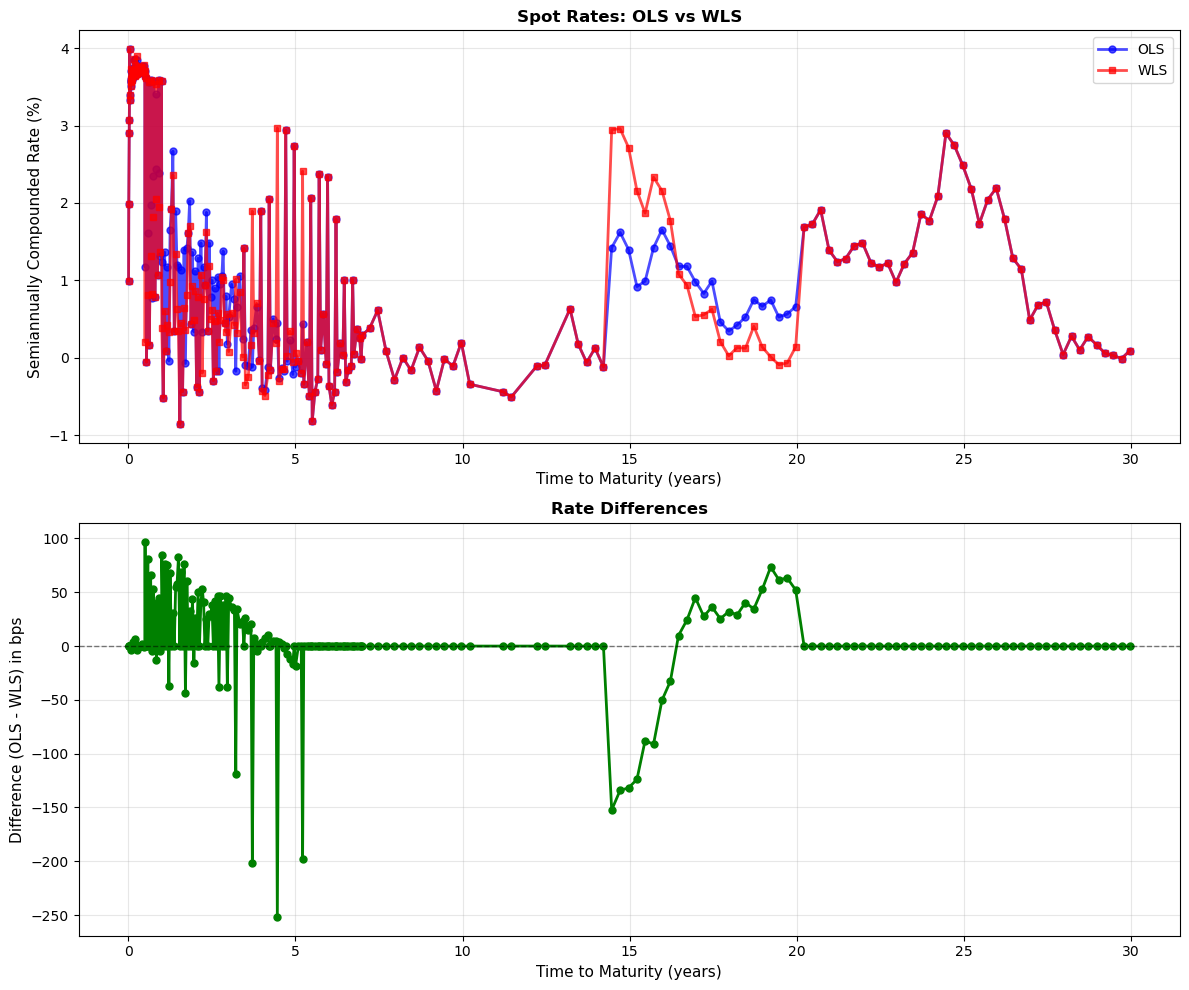


=== Comparison: OLS vs WLS ===
Mean difference: 3.05 bps
Mean absolute difference: 16.68 bps
Max absolute difference: 251.73 bps
RMSE: 38.45 bps

Conclusion: WLS shows notable differences from OLS (≥ 5 bps average).


In [6]:
## 2.4 Weighted Least Squares

# Calculate time since issue for each bond
issue_dates = pd.to_datetime(full_data_clean.loc[C_hat.index, 'issue date'])
time_since_issue = (quote_date - issue_dates).dt.days / 365.25

# Exponential weighting scheme: more recent = higher weight
half_life = 2.0  # years
lambda_decay = np.log(2) / half_life
weights = np.exp(-lambda_decay * time_since_issue)

# Normalize weights to sum to N (maintains scale)
weights = weights * len(weights) / weights.sum()

print("=== Weighting Scheme ===")
print(f"Half-life: {half_life} years")
print(f"Decay rate (λ): {lambda_decay:.4f}")
print(f"Weight range: [{weights.min():.4f}, {weights.max():.4f}]")
print(f"Mean weight: {weights.mean():.4f}")

# Weighted Least Squares: solve √W * C * z = √W * p
W = np.diag(weights)
C_weighted = np.sqrt(W) @ C_hat.values
p_weighted = np.sqrt(W) @ p_hat

z_wls = np.linalg.lstsq(C_weighted, p_weighted, rcond=None)[0]

# Create WLS discount factors DataFrame
discount_factors_wls = pd.DataFrame({
    'date': C_hat.columns,
    'discount_factor': z_wls,
    'ttm': (pd.to_datetime(C_hat.columns) - quote_date).days / 365.25
})

discount_factors_wls = discount_factors_wls[discount_factors_wls['ttm'] > 0].sort_values('ttm')
discount_factors_wls['rate_sa'] = 2 * (discount_factors_wls['discount_factor']**(-1/(2*discount_factors_wls['ttm'])) - 1)

# Compare OLS vs WLS
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Semiannual Rates Comparison
axes[0].plot(discount_factors_full['ttm'], discount_factors_full['rate_sa'] * 100,
             'o-', label='OLS', markersize=5, linewidth=2, color='blue', alpha=0.7)
axes[0].plot(discount_factors_wls['ttm'], discount_factors_wls['rate_sa'] * 100,
             's-', label='WLS', markersize=5, linewidth=2, color='red', alpha=0.7)
axes[0].set_xlabel('Time to Maturity (years)', fontsize=11)
axes[0].set_ylabel('Semiannually Compounded Rate (%)', fontsize=11)
axes[0].set_title('Spot Rates: OLS vs WLS', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Difference (OLS - WLS) in basis points
comparison = pd.merge(
    discount_factors_full[['ttm', 'rate_sa']],
    discount_factors_wls[['ttm', 'rate_sa']],
    on='ttm', suffixes=('_ols', '_wls')
)
comparison['diff_bps'] = (comparison['rate_sa_ols'] - comparison['rate_sa_wls']) * 10000

axes[1].plot(comparison['ttm'], comparison['diff_bps'], 'o-', 
             linewidth=2, markersize=5, color='green')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Time to Maturity (years)', fontsize=11)
axes[1].set_ylabel('Difference (OLS - WLS) in bps', fontsize=11)
axes[1].set_title('Rate Differences', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== Comparison: OLS vs WLS ===")
print(f"Mean difference: {comparison['diff_bps'].mean():.2f} bps")
print(f"Mean absolute difference: {np.abs(comparison['diff_bps']).mean():.2f} bps")
print(f"Max absolute difference: {np.abs(comparison['diff_bps']).max():.2f} bps")
print(f"RMSE: {np.sqrt(np.mean(comparison['diff_bps']**2)):.2f} bps")

if np.abs(comparison['diff_bps']).mean() < 5.0:
    print("\nConclusion: WLS shows modest differences from OLS (< 5 bps average).")
else:
    print("\nConclusion: WLS shows notable differences from OLS (≥ 5 bps average).")